In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import tensorflow_datasets as tfds

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TF version: 2.12.0
Hub version: 0.13.0
GPU is available


In [2]:


module_selection = ("inception_v3", 299) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 16 #@param {type:"integer"}
     


Using https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4 with input size (299, 299)


In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name="oxford_flowers102",
    split=['test', 'validation', 'train'],
    with_info=True,
    as_supervised=True,
    batch_size=32
)

In [4]:
IMAG_SIZE = 224 # All images will be resized to 224x224
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMAG_SIZE, IMAG_SIZE))
  return  image, label

In [5]:
train = raw_train.map(normalize_img)
validation = raw_validation.map(normalize_img)
test = raw_test.map(normalize_img)
     

In [6]:
# print("Building model with", MODULE_HANDLE)
conv_base = VGG19(include_top=False, weights='imagenet', input_shape=(IMAG_SIZE, IMAG_SIZE,3))
for layer in conv_base.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    conv_base,
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1072, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=metadata.features["label"].num_classes)
])

model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 1072)              4391984   
                                                                 
 dropout (Dropout)           (None, 1072)              0         
                                                                 
 dense_2 (Dense)             (None, 102)               109446    
                                                                 
Total params: 127,290,358
Trainable params: 107,265,974


In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

earlystopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3), 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
     

In [8]:
train = train.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat().shuffle(512)
validation = validation.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat()

In [9]:
steps_per_epoch = metadata.splits["train"].num_examples / BATCH_SIZE 
validation_steps = metadata.splits["validation"].num_examples / BATCH_SIZE
EPOCHS = 40
hist = model.fit(
    x=train,
    epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback],
    verbose=1).history

Epoch 1/40
63/63 [==============================] - 68s 361ms/step - loss: 5.4931 - accuracy: 0.0518 - val_loss: 4.6558 - val_accuracy: 0.0518
Epoch 2/40
63/63 [==============================] - 22s 350ms/step - loss: 3.9086 - accuracy: 0.1621 - val_loss: 4.2731 - val_accuracy: 0.1104
Epoch 3/40
63/63 [==============================] - 19s 301ms/step - loss: 3.5137 - accuracy: 0.2246 - val_loss: 3.8800 - val_accuracy: 0.1543
Epoch 4/40
63/63 [==============================] - 22s 352ms/step - loss: 2.9753 - accuracy: 0.3076 - val_loss: 3.3355 - val_accuracy: 0.2568
Epoch 5/40
63/63 [==============================] - 20s 319ms/step - loss: 2.7756 - accuracy: 0.3340 - val_loss: 3.0691 - val_accuracy: 0.2637
Epoch 6/40
63/63 [==============================] - 19s 299ms/step - loss: 2.3621 - accuracy: 0.4150 - val_loss: 2.7068 - val_accuracy: 0.3252
Epoch 7/40
63/63 [==============================] - 22s 355ms/step - loss: 2.0755 - accuracy: 0.4658 - val_loss: 2.3109 - val_accuracy: 0.3975

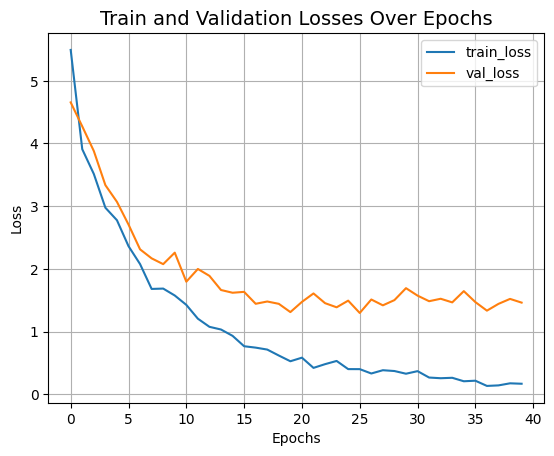

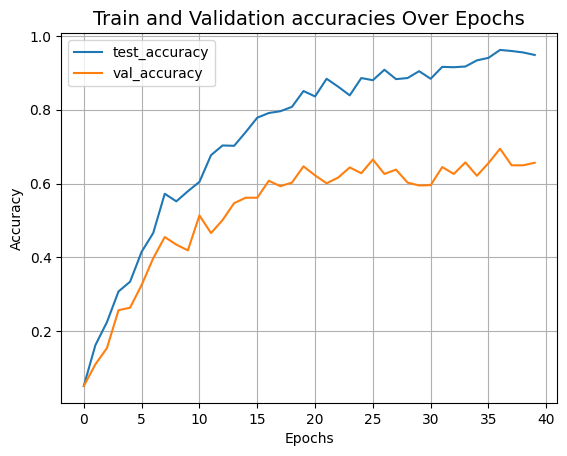

In [10]:
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(hist["accuracy"], label="test_accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [11]:
image_batch = []
label_batch = []
image_batch, label_batch = next(iter(test))

t = list(test.as_numpy_iterator())

for i in range(len(test)-1):
    image_batch = np.append(image_batch, t[i+1][0], axis=0)
    label_batch = np.append(label_batch, t[i+1][1], axis=0)


image_batch = image_batch
label_batch = label_batch

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
# predicted_class_names = class_names[predicted_ids]
# print(predicted_class_names)

32/32 [==============================] - 14s 286ms/step


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Converter as previsões em rótulos de classe
predicted_classes = predicted_ids#np.argmax(probs, axis=1)

# Obter os rótulos verdadeiros do conjunto de dados de validação
true_classes = label_batch#np.argmax(y_test, axis=1)

# Obter os nomes das classes
# class_names = list(validgen.class_indices.keys())

# Calcular a precisão
accuracy = np.mean(predicted_classes == true_classes)
print('Precisão:', accuracy)

Precisão: 0.6313725490196078


In [13]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Calcular a precisão, recall e F1-score para cada classe
report = classification_report(true_classes, predicted_classes, target_names=np.array(metadata.features['label'].names))

# Exibir o relatório de classificação
print(report)

                           precision    recall  f1-score   support

            pink primrose       1.00      0.30      0.46        10
hard-leaved pocket orchid       0.91      1.00      0.95        10
         canterbury bells       0.50      0.20      0.29        10
                sweet pea       0.33      0.10      0.15        10
         english marigold       0.67      0.60      0.63        10
               tiger lily       0.67      0.20      0.31        10
              moon orchid       0.57      0.40      0.47        10
         bird of paradise       1.00      0.90      0.95        10
                monkshood       0.50      0.60      0.55        10
            globe thistle       0.91      1.00      0.95        10
               snapdragon       0.57      0.80      0.67        10
              colt's foot       0.40      0.80      0.53        10
              king protea       1.00      0.30      0.46        10
            spear thistle       0.82      0.90      0.86     